# FashionMNIST
Load images from the [Fashion-MNIST data](https://github.com/zalandoresearch/fashion-mnist)


The dataset comprised of 60,000 small square 28x28 pixel grayscale images of items of 10 types of clothing with 0-9 class labels.
class labels:
* 0: T-shirt/top
* 1: Trouser
* 2: Pullover
* 3: Dress
* 4: Coat
* 5: Sandal
* 6: Shirt
* 7: Sneaker
* 8: Bag
* 9: Ankle boot

### Load the Fashion-MNIST data
* Use ``torch.utils.data.dataset``
* Data path: data
* Apply transformations to the data (turning all images into Tensor's for training a NN

### Train and CNN to classify images
* Load in both training and test datasets from the FashionMNIST class



## Import the Necessary Packages

In [2]:
# basic torch libraries
import torch
import torchvision

# data loading and transforming
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

# basic libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### The output of ``torchvision`` are PILImage images of range [0, 1]
* Transform them to Tensor for input into a CNN

In [4]:
# Defin a transform to read the data in as a Tensor
data_transform = transforms.ToTensor()

# Choose the training and test datasets
path = './data'

# Training datasets
train_data = FashionMNIST(root=path,
                          train=True,
                          download=False,
                          transform=data_transform)

# Test datasets
test_data = FashionMNIST(root=path,
                         train=False,
                         download=False,
                         transform=data_transform)



# Print out some stats about the training data
print('Train data, number of images', len(train_data))

# Print out some stats about the training data
print('Test data, number of images', len(test_data))

Train data, number of images 60000
Test data, number of images 10000


## Data iteration anbatching
``torch.utils.data.DataLoader`` is an iterator that allows to batch and shuffle the data


In [6]:
# shuffle the data and load in image/label data in batches of size 20
# Depends on large or small size of batch size will affect the loss
batch_size = 20

# load train
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# load test
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Using ``dataiter.next()`` for cell iterates over the training dataset of loaded a random batch image/label data.

Plots the batch of images and labels in a ``2*batch_size/2`` grid.


/home/eightun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


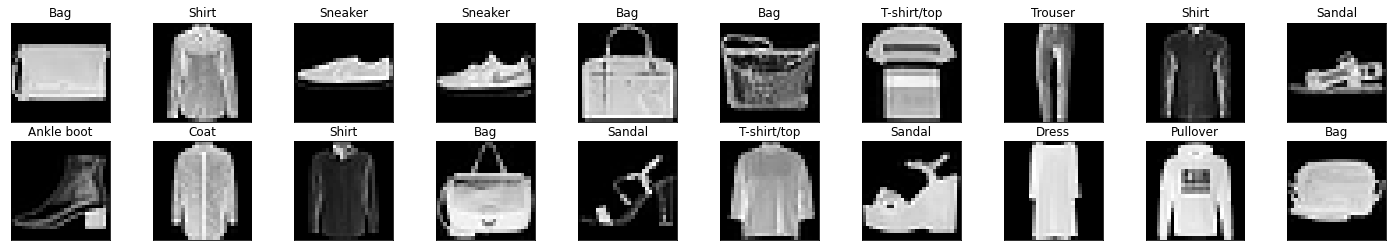

In [7]:
# obtain one batch of training images
# iter
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert to numpy

# plot the images in the batch with labels
fig = plt.figure(figsize=(25, 4)) # fig size
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

## View an image
* Normalize
* grayscale image

### Normalization
Normalization ensures that, as we go through a feedforward and then backpropagation step in training our CNN, that each image feature will fall within a similar range of values and not overly activate any particular layer in our network. During the feedfoward step, a network takes in an input image and multiplies each input pixel by some convolutional filter weights (and adds biases!), then it applies some activation and pooling functions. Without normalization, it's much more likely that the calculated gradients in the backpropagaton step will be quite large and cause our loss to increase instead of converge



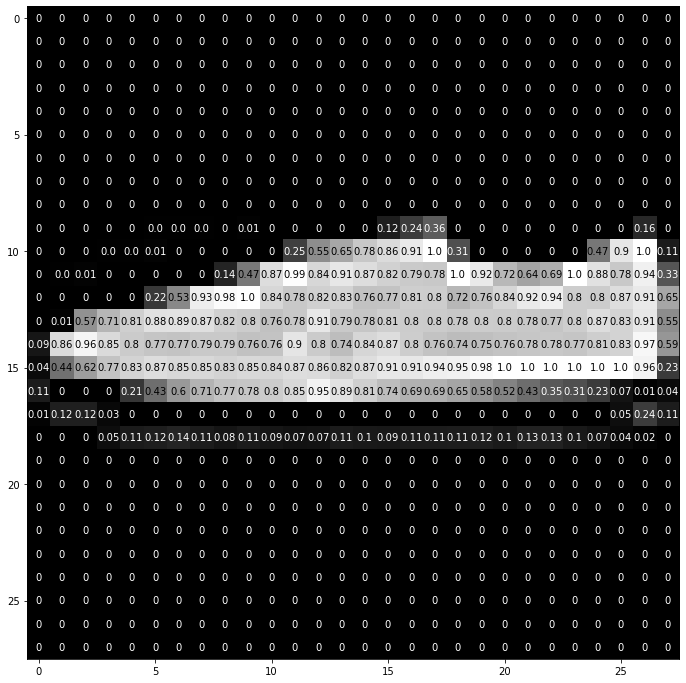

In [8]:
# select an image by index
idx = 2
img = np.squeeze(images[idx])

# display the pixel values in the image
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

### NN Architecture
* Architecture for simple ConvNet [INPUT-CONV-RELU-POOL-FC]
* [NN Layers](http://pytorch.org/docs/master/nn.html)
* Flattening used for the output of conv/pooling layer to a linear layer. In Keras used ``Flatten()``. In Pytorch used an input x with ``x = x.view(x.size(0), -1)``
* Keep tract output dimension for case ``output_dim = (W-F+2P)/S + 1``
    * Input volume size(W)
    * Receptive field size of the Conv Layer neurons(F)
    * The sride with which applied(S)
    * The amount of zero padding used(P)

# Necessary Packages for NN Module

In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [12]:
# Define Layers of a model
# Will use [INPUT-CONV-RELU-POOL-CONV-RELU-POOL-FC]
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # 1 input image channel(grayscale), 10 output channels/features maps
        # Applies a 2D convolution over an input signal composed of several input planes.
        # 3x3 square convolution kernel
        # output_dim = (28-3)/1 + 1 = 26
        # output Tensor for one image will have the dimensions: (10, 26, 26)
        self.conv1 = nn.Conv2d(1, 10, 3)
        
        # maxpool layer with kernel_size=2, stride=2
        # Output_dim = 26/2 = 13
        # output Tensor for one image will have the dimensions: (10, 13, 13)
        self.pool = nn.MaxPool2d(2,2)
        
        # Apply Second conv layer: 10 inputs, 20 outputs
        # 3x3 square convolution kernel
        # output_dim = (13-3)/1 + 1 = 11
        # output Tensor for one image will have the dimensions: (20, 11, 11)
        self.conv2d = nn.Conv2d(10, 20, 3)
        # Outpu_dim for pooling after secon conv (20, 5, 5); 5.5 is rounded down
        
        # FC
        # 20 outputs * the 5*5 filtered/poled map size
        # 10 output channels (for the 10 classes)
        self.fc1 = nn.Linear(20*5*5, 10)
        
    # feedforward behavior
    def forward(self, x):
        # Apply [CONV-RELU-POOL-CONV-RELU-POOL]
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # Flattening used for the output of conv/pooling layer to a linear laye
        # Flatten the inputs into a vector
        x = x.view(x.size(0), -1)
        
        # One linear layer
        x = F.relu(self.fc1(x))
        
        # Apply softmax layer to convert the 10 outputs (0-9) into a distribution prob of class scores
        x = F.log_softmax(x, dim=1)
        
        return x
    
        
        

In [13]:
# Instantiate and print Net
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=10, bias=True)
)


# Loss function and Optimizer

* Loss function typically uses cross entropy loss ``criterion = nn.CrossEntropyLoss()``; Cross entropy loss combines softmax and NLL loss (``nn.NLLLoss()``).
* NLL Loss being uesd for the output of Net is a distribution of class scores which this condtion fit to the model.

* Some standard stochastic optimizers are stochastic gradient descent and Adam.

In [14]:
# additional necessary package for optimizer
import torch.optim as optim

# Apply NLL Loss for distribution of class scores
criterion = nn.NLLLoss()

# Optimizer used SGD with small learning rate 0.001
optimizer = optim.SGD(net.parameters(), lr=0.001)